In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

# 데이터 불러오기

데이터를 불러오기 위해 `torchvision`과 `torch.utils.data` 패키지를 사용함

일단, 개미/벌을 분류하는 모델을 학습하려고 함.

개미와 벌 각각의 학습용 이미지는 대략 120장 정도 있고, 75개의 검증용 이미지가 있음.

이 데이터셋(`hymenoptera_data`)은 ImageNet의 아주 작은 일부임



In [8]:
data_transforms = {
    # transforms.Compose: 여러개의 transform을 묶음
    'train': transforms.Compose([
        # random으로 이미지를 크롭하여 224*224 사이즈의 사진으로 만들 것
        transforms.RandomResizedCrop(224),
        # 이미지를 랜덤으로 수평으로 뒤집음
        transforms.RandomHorizontalFlip(),
        # PIL image 혹은 numpy.ndarray를 tensor로 바꿈
        transforms.ToTensor(),
        # image normalize를 하게 되면 CNN 성능 좋아짐
        # <https://discuss.pytorch.org/t/understanding-transform-normalize/21730/5>
        # normalization을 통해 데이터를 범위 안으로 집어넣고, skewness를 줄일 수 있으므로 학습을 빠르고 효과적으로 할 수 있게 함
        # transforms.Normalize(mean, std)
        # mean과 std는 각각 (r,g,b) 채널을 가짐
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # 주어진 이미지를 256*256 사이즈로 바꿈
        transforms.Resize(256),
        # 중앙에서 크롭하여 224*224 이미지를 만듦
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'
image_datasets = {
    # 계층적인 폴더 구조를 가지고 있는 데이터셋을 불러올 때 사용
    # 이미지들이 자신의 label 이므로 된 폴더 안에 들어가 있는 구조라면, ImageFolder 라이브러리를 이용하여 이를 바로 불러와 객체로 만들어줌
    # <https://ndb796.tistory.com/373>
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']
}
# num_works에 대한 고찰 <https://jybaek.tistory.com/799>
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']
}
dataset_sizes = {
    x: len(image_datasets[x]) for x in ['train', 'val']
}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 일부 이미지 시각화하기

데이터를 이해하기 위해 몇 가지를 시각화해 보자

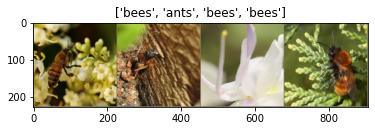

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

# training data로부터 batch를 얻음
# iter(): iteration을 return함
# batch size에 따라 달라짐
inputs, classes = next(iter(dataloaders['train']))
# batch로부터 grid image를 만듦
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 모델 학습하기

모델을 학습하기 위한 일반 함수들을 작성해 보자.

- Scheduling the learning rate(학습률 관리)
- 최적의 모델 저장

아래에서 `scheduler` 매개변수는 `torch.optim.lr_scheduler`의 LR 스케쥴러 object임

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # since: 현재 시각 저장
    since = time.time()

    # pytorch에서 `torch.nn.Module` 모델의 학습 가능한 매개변수(weight, bias)들은 모델의 매개변수에 포함되어 있음
    # model.parameters()로 접근 가능
    # state_dict는 각 계층을 매개변수 텐서로 매핑되는 python dictionary object임
    # 이때, 학습 가능한 매개변수를 갖는 계층(합성곱 게층, 선형 계층 등) 미ㅣㅊ 등록된 버퍼들만이 모델의 state_dic에 항목을 가짐을 유의
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # epoch 만큼 training을 시킴
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                # 매 단계마다 입력(inputs)과 정답(labels)을 디바이스에 전달해야 함
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                # 역전파 단계 전에, Optimizer 객체를 사용하여 (모델의 학습 가능한 가중치인) 갱신할 변수들에 대한 모든 변화도를 0으로 만듦
                # 기본적으로 .backward()를 호출할 때 마다 변화도가 buffer에 덮어씌워지는 것이 아니라 누적되기 때문임
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        # 역전파 단계: 모델의 매개변수에 대한 손실의 변화도를 계산함
                        loss.backward()
                        # 최적화: Optimizer의 step 함수를 호출하면 매개변수가 갱신됨
                        optimizer.step()

                # 통계
                # loss.item(): loss의 scala 값
                # inputs.size(0): give the total images in each batch
                running_loss += loss.item() * inputs.size(0)
                # torch.sum(input): returns the sum of all elements in the input tensor
                running_corrects += torch.sum(preds == labels.data)

            # If you don’t call it, the learning rate won’t be changed and stays at the initial value.
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

# 모델 예측값 시각화하기

일부 이미지에 대한 예측값을 보여주는 일반화된 함수

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 합성곱 신경망 미세조정(finetuning)

미리 학습한 모델을 불러온 후 마지막에 완전히 연결된 계층을 초기화 함

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# 각 출력 샘플의 크기는 2로 설정함
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있음

model_ft.tc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0/1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/lab405b/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.7183 Acc: 0.6352
val Loss: 1.6089 Acc: 0.5752

Epoch 1/24
----------
train Loss: 0.7487 Acc: 0.7377
val Loss: 0.8871 Acc: 0.7190

Epoch 2/24
----------
train Loss: 0.8654 Acc: 0.7172
val Loss: 0.7998 Acc: 0.7255

Epoch 3/24
----------
train Loss: 0.6695 Acc: 0.7377
val Loss: 0.5424 Acc: 0.7908

Epoch 4/24
----------
train Loss: 0.7149 Acc: 0.7131
val Loss: 0.2426 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.3426 Acc: 0.8525
val Loss: 0.3331 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.7919 Acc: 0.7541
val Loss: 0.4514 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.5541 Acc: 0.7623
val Loss: 0.3656 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3679 Acc: 0.8197
val Loss: 0.3527 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.2716 Acc: 0.8648
val Loss: 0.2869 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2619 Acc: 0.8811
val Loss: 0.3012 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2806 Acc: 0.8770
val Loss: 0.3189 Acc: 0.9020

Ep

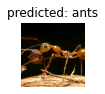

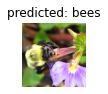

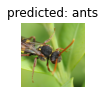

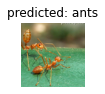

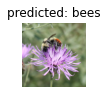

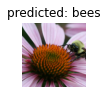

In [14]:
visualize_model(model_ft)

# 고정된 특징 추출기로써의 합성곱 신경망

마지막 계층을 제외한 신경망의 모든 부분을 고정해야 함. (왜???????)

`requires_grad == False`로 설정하여 매개변수를 고정하여 `backward()` 중에 경사도가 개선되지 않도록 해야 함

In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# 학습 및 평가하기

대부분의 신경망에서 경사도를 계산할 필요가 없으므로 시간이 적게 걸릴 것.

순전파는 계산이 필요함.

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5814 Acc: 0.6516
val Loss: 0.2205 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.6077 Acc: 0.7295
val Loss: 0.3329 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.5851 Acc: 0.7705
val Loss: 0.1754 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4240 Acc: 0.8320
val Loss: 0.3059 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5535 Acc: 0.7828
val Loss: 0.1978 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4041 Acc: 0.8320
val Loss: 0.2548 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.4515 Acc: 0.7951
val Loss: 0.2186 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4215 Acc: 0.8156
val Loss: 0.2155 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.4319 Acc: 0.8074
val Loss: 0.2263 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3717 Acc: 0.8566
val Loss: 0.2076 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2859 Acc: 0.8975
val Loss: 0.2057 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2544 Acc: 0.8852
val Loss: 0.1722 Acc: 0.9477

Ep

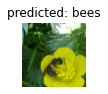

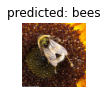

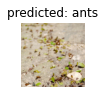

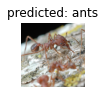

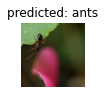

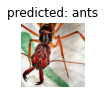

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()